# Udacity A/B Testing by Google

The final project of Udacity A/B Testing by Google.

[This project](https://classroom.udacity.com/courses/ud257/lessons/4126079196/concepts/42072285530923) is from Udacity free course [A/B Testing by Google](https://www.udacity.com/course/ab-testing--ud257).

---

README: https://github.com/ZacksAmber/Udacity-A-B-Testing-by-Google

Author: Zacks Shen

YouTube: https://youtu.be/13d0D6zCwkY

---

Reference:

> [AB Testing With Python - Walkthrough Udacity's Course Final Project](https://www.kaggle.com/tammyrotem/ab-tests-with-python/comments)

> [Udacity-AB-Testing-Final-Project](https://github.com/shubhamlal11/Udacity-AB-Testing-Final-Project)

In [1]:
############
# Packages #
############
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy import stats
import datascientists as ds
from IPython.display import display, Latex

############
# Settings #
############
# Pandas Settings
pd.set_option('max_rows', 20)
pd.set_option('display.colheader_justify', 'left')
# plotly.express Settings
# px.defaults.template = 'plotly_white' # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
px.defaults.width = 1200
px.defaults.height = 600
# plotly.io Settings for both plotly.graph_objects and plotly.express
pio.templates.default = "plotly_white" # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
pio.kaleido.scope.default_format = 'svg'
pio.kaleido.scope.default_scale = 1

#############
# Documents #
#############
# IPython
#    https://ipython.org/ipython-doc/stable/interactive/reference.html#dynamic-object-information
# Pandas
#    https://pandas.pydata.org/pandas-docs/stable/reference/index.html#api
# Numpy
#    https://numpy.org/doc/stable/reference/index.html
# Plotly
#    https://plotly.com/python-api-reference/index.html
# Plotly - Image Export Settings (Kaleido)
#    https://plotly.com/python/static-image-export/
# Statistical functions (scipy.stats)
#    https://docs.scipy.org/doc/scipy/reference/stats.html

## Hypothesis Testing

- control group, also called group`A`.
- experiment group, also called group `B`.

$\displaystyle H_0: P_B - P_A = 0$

$\displaystyle H_1: P_B - P_A \neq 0 \Rightarrow P_B - P_A = d$

$\alpha$ = P({reject null | null true})

$\beta$ = P({failed to reject | null false})

<img src="https://i.stack.imgur.com/R0ncP.png" width=800 height=400 />

<img src="http://strata.uga.edu/8370/lecturenotes/images/errors.png" width=800 height=400 />


- **Null Hypothesis**: There is no difference in group `A` and `B`.
- **Alternative Hypothesis**: There is a difference in group `A` and `B`.

---

## Metrics Choice

A/B Testing requires two types of metrics: Invariant Metrics and Evaluation Metrics.

The following are possible metrics:

Any place "unique cookies" are mentioned, the uniqueness is determined by day. (That is, the same cookie visiting on different days would be counted twice.) User-ids are automatically unique since the site does not allow the same user-id to enroll twice.

- **Number of cookies**: That is, number of unique cookies to view the course overview page. ($d_{min}=3000$)
- **Number of user-ids**: That is, number of users who enroll in the free trial. ($d_{min}=50$)
- **Number of clicks**: That is, number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). ($d_{min}=240$)
- **Click-through-probability**: That is, number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page. ($d_{min}=0.01$)
- **Gross conversion**: That is, number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. ($d_{min}=0.01$)
- **Retention**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of user-ids to complete checkout. ($d_{min}=0.01$)
- **Net conversion**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. ($d_{min}=0.0075$)


---

### The Process of Users' Behaviors

  1. Visit Udacity website
  2. Open course page (`cookies` or called `pageviews`)
  3. Choose "start free trial" or "access course materials".
     1. "access course materials"
        1. Free users -> no charging
     2. "start free trial" (`clicks`)
        1. Less than 5 hours per week for learning -> <mark>Experiment change: suggested for switching to "access course materials"</mark>
        2. 5 hours per week for learning -> stay here (`user-id`)
           1. Course completion & Subscription (`enrollment` & `payment`)
           2. Course completion & Cancel Subscription (`enrollment`)
           3. Course incomplete & Subscription (`enrollment` & `payment`)
           4. Course incomplete & Cancel Subscription (`enrollment`)

---

### Choosing Invariant Metrics

**Q: Choose invariant metrics and explain the reasons.**

**Invariant metrics:**
- Population sizing metrics, based on your unit of diversion. Your population of control and experiment should be comparable.
- Actual invariants, those metrics that shouldn’t change when you run your experiment.

**A:**

|Metric Name|Metric Formula|$d_{min}$|Notation|Python Notation|Reason|
|:-:|:-:|:-:|:-:|:-:|:-:|
|Number of cookies|#number of unique cookies to view the course overview page|3000 cookies|$C_{cookies}$|`cookies`|Population sizing metric|
|Number of clicks|#number of unique cookies to click the "Start free trial" button|240 clicks|$C_{clicks}$|`clicks`|Population sizing metric|
|Click-through-probability|$\displaystyle \frac{C_{clicks}}{C_{cookies}}$|0.01|CTP|`CTP`|Population sizing metric|

- Number of cookies is our population metric. Additionally, the Experiment change happening before the cookies are recorded. Therefore, Number of cookies is an invariant metric.
- Number of clicks, which are recorded before the Experiment change occurred.
- Click-through-probability, which are recorded before the Experiment change occurred.

---

## Calculating Standard Error

**Q: For each metric you selected as an evaluation metric, make an analytic estimate of its standard error, given a sample size of 5,000 cookies visiting the course overview page. Enter each estimate in the appropriate box to 4 decimal places**

Hints
Hint 1: Make sure you are only using information given in the [table of baseline values](https://docs.google.com/a/knowlabs.com/spreadsheets/d/1MYNUtC47Pg8hdoCjOXaHqF-thheGpUshrFA21BAJnNc/edit#gid=0). Do not use [the results of the experiment](https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0), since this step should be done before the experiment is run.

Hint 2: Make sure you figure out how many units of analysis will correspond to 5000 pageviews for each metric. Again, use the given [baseline values](https://docs.google.com/a/knowlabs.com/spreadsheets/d/1MYNUtC47Pg8hdoCjOXaHqF-thheGpUshrFA21BAJnNc/edit#gid=0).

> [Standard error](https://en.wikipedia.org/wiki/Standard_error)

$\displaystyle \sigma^2 = p(1 - p)$

$\displaystyle SE = \sqrt{\frac{\sigma^2}{n}} = \frac{\sigma}{\sqrt{n}}$

---

**A:**

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th></th>
      <th>Standard Error</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Gross conversion</th>
      <td>0.0202</td>
    </tr>
    <tr>
      <th>Retention</th>
      <td>0.0549</td>
    </tr>
    <tr>
      <th>Net conversion</th>
      <td>0.0156</td>
    </tr>
  </tbody>
</table>

In [2]:
# Source: https://docs.google.com/spreadsheets/d/1MYNUtC47Pg8hdoCjOXaHqF-thheGpUshrFA21BAJnNc/edit#gid=0
baseline = pd.read_csv(
    'https://raw.githubusercontent.com/ZacksAmber/Udacity-A-B-Testing-by-Google/main/data/Final%20Project%20Baseline%20Values%20-%20Sheet1.csv',
    index_col=False,
    header=None,
    names=['Metric Name', 'Value']
)

baseline

,Metric Name,Value
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


In [3]:
# Define baseline metrics
cookies = 40000
clicks = 3200
# enrollments is counted by user-ids
enrollments = 660
# Enrollment probability
p_enrollments = enrollments / cookies
# Click-through-probability
CTP = clicks / cookies
gross_conversion = enrollments / clicks
retention = 0.53
net_conversion = gross_conversion * retention

# Dictonary of Gross conversion
GC = {}
GC['p'] = gross_conversion
GC['d_min'] = 0.01
GC['n'] = clicks

# Dictonary of Retention
R = {}
R['p'] = retention
R['d_min'] = 0.01
R['n'] = enrollments

# Dictonary of Net Conversion
NC = {}
NC['p'] = net_conversion
NC['d_min'] = 0.0075
NC['n'] = clicks

In [4]:
# Define function ge_se to calculate Standard Error
def get_se(p, n):
    SE = np.sqrt(p * (1-p) / n)
    return round(SE, 4)

GC['SE'] = get_se(GC['p'], GC['n'])
R['SE'] = get_se(R['p'], R['n'])
NC['SE'] = get_se(NC['p'], NC['n'])

print(GC)
print(R)
print(NC)

{'p': 0.20625, 'd_min': 0.01, 'n': 3200, 'SE': 0.0072}
{'p': 0.53, 'd_min': 0.01, 'n': 660, 'SE': 0.0194}
{'p': 0.10931249999999999, 'd_min': 0.0075, 'n': 3200, 'SE': 0.0055}


Given the sample size of cookies is 5,000, and the above calculations are based on the cookies of 40,000. Therefore, we need to adjust each `n` to the ratio of 5,000:40,000.

In [5]:
sample_cookies = 5000
ratio = sample_cookies / cookies

df_SE = pd.DataFrame({
    'Standard Error': [get_se(GC['p'], GC['n'] * ratio), 
                       get_se(R['p'], R['n'] * ratio), 
                       get_se(NC['p'], NC['n'] * ratio)]
    }, 
    index=['Gross conversion', 'Retention', 'Net conversion']
)

df_SE

,Standard Error
Gross conversion,0.0202
Retention,0.0549
Net conversion,0.0156


---

## Sizing

- Calculating Number of Pageviews
- Choosing Duartion and Exposure

---

### Calculating Number of Pageviews

**Q: Choosing Number of Samples given Power**

Using the analytic estimates of variance, how many pageviews total (across both groups) would you need to collect to adequately power the experiment? Use an alpha of 0.05 and a beta of 0.2. Make sure you have enough power for each metric.

**A:**

**Will you use the Bonferroni correction in your analysis phase?**
- No

For $d_{min} = [0.01, 0.01, 0.0075]$ of Gross conversion, Retention, and Net conversion, none of $\alpha_{individual} = [0.0172, 0.0464, 0.0132]$ of Bonferroni corretion is qualified to $d_{min}$. Therefore, I decided not to use Bonferroni correction due to its conservativeness

**Which evaluation metrics did you select?**
- Gross conversion
- Retention
- Net conversion

**How many pageviews will you need?**

Use alpha = 0.05 and beta = 0.2. Round your answer to the nearest integer, if necessare. 
- `471212`

<table id="T_86970_"><thead>    <tr>        <th class="blank level0"></th>        <th class="col_heading level0 col0">Baseline Conversion Rate</th>        <th class="col_heading level0 col1"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-533-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>d</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>m</mi><mi>i</mi><mi>n</mi></mrow></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-17134" style="width: 2.121em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.711em; height: 0px; font-size: 122%;"><span style="position: absolute; clip: rect(1.301em, 1001.71em, 2.531em, -999.997em); top: -2.182em; left: 0em;"><span class="mrow" id="MathJax-Span-17135"><span class="msubsup" id="MathJax-Span-17136"><span style="display: inline-block; position: relative; width: 1.711em; height: 0px;"><span style="position: absolute; clip: rect(3.145em, 1000.55em, 4.238em, -999.997em); top: -4.027em; left: 0em;"><span class="mi" id="MathJax-Span-17137" style="font-family: STIXMathJax_Normal-italic;">𝑑</span><span style="display: inline-block; width: 0px; height: 4.033em;"></span></span><span style="position: absolute; top: -3.89em; left: 0.55em;"><span class="texatom" id="MathJax-Span-17138"><span class="mrow" id="MathJax-Span-17139"><span class="mi" id="MathJax-Span-17140" style="font-size: 70.7%; font-family: STIXMathJax_Normal-italic;">𝑚</span><span class="mi" id="MathJax-Span-17141" style="font-size: 70.7%; font-family: STIXMathJax_Normal-italic;">𝑖</span><span class="mi" id="MathJax-Span-17142" style="font-size: 70.7%; font-family: STIXMathJax_Normal-italic;">𝑛</span></span></span><span style="display: inline-block; width: 0px; height: 4.033em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.189em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.246em; border-left: 0px solid; width: 0px; height: 1.171em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>d</mi><mrow class="MJX-TeXAtom-ORD"><mi>m</mi><mi>i</mi><mi>n</mi></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-533">d_{min}</script></th>        <th class="col_heading level0 col2">Alpha</th>        <th class="col_heading level0 col3">Beta</th>        <th class="col_heading level0 col4">Power</th>        <th class="col_heading level0 col5">Sample Size</th>        <th class="col_heading level0 col6">Pageviews(cookies)</th>    </tr></thead><tbody>
                <tr>
                        <th id="T_86970_level0_row0" class="row_heading level0 row0">Gross conversion</th>
                        <td id="T_86970_row0_col0" class="data row0 col0">0.206250</td>
                        <td id="T_86970_row0_col1" class="data row0 col1">0.010000</td>
                        <td id="T_86970_row0_col2" class="data row0 col2">0.050000</td>
                        <td id="T_86970_row0_col3" class="data row0 col3">0.200000</td>
                        <td id="T_86970_row0_col4" class="data row0 col4">0.800000</td>
                        <td id="T_86970_row0_col5" class="data row0 col5">25,835</td>
                        <td id="T_86970_row0_col6" class="data row0 col6">645,875</td>
            </tr>
            <tr>
                        <th id="T_86970_level0_row1" class="row_heading level0 row1">Retention</th>
                        <td id="T_86970_row1_col0" class="data row1 col0">0.530000</td>
                        <td id="T_86970_row1_col1" class="data row1 col1">0.010000</td>
                        <td id="T_86970_row1_col2" class="data row1 col2">0.050000</td>
                        <td id="T_86970_row1_col3" class="data row1 col3">0.200000</td>
                        <td id="T_86970_row1_col4" class="data row1 col4">0.800000</td>
                        <td id="T_86970_row1_col5" class="data row1 col5">39,115</td>
                        <td id="T_86970_row1_col6" class="data row1 col6">4,741,212</td>
            </tr>
            <tr>
                        <th id="T_86970_level0_row2" class="row_heading level0 row2">Net conversion</th>
                        <td id="T_86970_row2_col0" class="data row2 col0">0.109312</td>
                        <td id="T_86970_row2_col1" class="data row2 col1">0.007500</td>
                        <td id="T_86970_row2_col2" class="data row2 col2">0.050000</td>
                        <td id="T_86970_row2_col3" class="data row2 col3">0.200000</td>
                        <td id="T_86970_row2_col4" class="data row2 col4">0.800000</td>
                        <td id="T_86970_row2_col5" class="data row2 col5">27,413</td>
                        <td id="T_86970_row2_col6" class="data row2 col6">685,325</td>
            </tr>
    </tbody></table>

---

#### Familywise Error Rate (FWER)

**Less conservative multiple comparison methods**

The [Bonferroni correction](http://en.wikipedia.org/wiki/Bonferroni_correction) is a very simple method, but there are many other methods, including the [closed testing procedure](http://en.wikipedia.org/wiki/Closed_testing_procedure), the [Boole-Bonferroni bound](http://en.wikipedia.org/wiki/Bonferroni_bound), and the [Holm-Bonferroni method](http://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method). [This article](http://en.wikipedia.org/wiki/Multiple_comparisons_problem) on multiple comparisons contains more information, and this article contains more information about the false discovery rate (FDR), and methods for controlling that instead of the familywise error rate (FWER).

**Tracking multiple metrics**

Problem: Probability of any false positive increases as you increase number of metrics

Solution: Use higher confidence level for each metric

Method 1: Assume independence
- $\alpha_{overall} = 1 - (1 - \alpha_{individual})^n$

Method 2: Bonferroni correction
- simple
- no assumptions
- too conservative - guaranteed to give $\displaystyle \alpha_{overall}$ at least as small as specified
- $\displaystyle \alpha_{individual} = \frac{\alpha_{overall}}{n}$

for example:

$\displaystyle \alpha_{overall} = 0.05, n=3 \Rightarrow \alpha_{individual} = 0.0167$

---

Margin of Error

> [Margin of Error](https://en.wikipedia.org/wiki/Margin_of_error)

$\displaystyle MOE_{\gamma} = Z_{\gamma} \times SE = d_{min}$

In [6]:
# Z-Score

# Signifiance Level
alpha = 0.05
# n is the number of eveluation metrics.
n = 3

# individual a of method 1
z1 = stats.norm.ppf(1 - (alpha**(1/n) / 2))

# individual a of method 2, Bonferroni correction
z2 = stats.norm.ppf(1 - (alpha/n) / 2)

print(z1)
print(z2)

0.8994685321132673
2.3939797998185104


In [7]:
# Margin of Error

# Set NumPy printionoptions
np.set_printoptions(suppress=True)
# Calculate margin of error
m1 = z1 * np.array([GC['SE'], R['SE'], NC['SE']])
m2 = z2 * np.array([GC['SE'], R['SE'], NC['SE']])

print(np.around(m1, 4))
print(np.around(m2, 4))

[0.0065 0.0174 0.0049]
[0.0172 0.0464 0.0132]


In [8]:
d_min = np.array([0.01, 0.01, 0.0075])

print(m1 < d_min)
print(m2 < d_min)

[ True False  True]
[False False False]


With respect to FWER control, the Bonferroni correction can be conservative if there are a large number of tests and/or the test statistics are positively correlated.

Thus, I decided not to use Bonferroni correction.

---

### Sample Size per Variation

$\displaystyle  \hat p_{pool}= \frac{X_{cont}+X_{exp}}{N_{cont}+ N_{exp}}$

$\displaystyle \sigma^2 = \hat p_{pool}(1 - \hat p_{pool})$

$\displaystyle SE_{pool} = \sqrt{\sigma^2 \cdot (\frac{1}{N_{cont}}+\frac{1}{N_{exp}})}$

For calculating the minimize sample size of control and experiment, $N_{cont} = N_{exp}= N$, then we have:
$\displaystyle \hat p_{pool} = \frac{X_{cont}+X_{exp}}{N + N} = \frac{X_{cont}}{2N} + \frac{X_{exp}}{2N} = \frac{p_{cont}}{2} + \frac{p_{exp}}{2} = \frac{p_{cont} + p_{exp}}{2}$

Therefore:

$\displaystyle SE_{pool} = \sqrt{\sigma^2 \cdot (\frac{1}{N_{cont}}+\frac{1}{N_{exp}})} = \sqrt{\sigma^2 \cdot (\frac{1}{N} + \frac{1}{N})} = \sqrt{\sigma^2 \cdot \frac{2}{N}}$

In this case, $d_{min}$ is equal to Margin of Error.

$d_{min} = p_{exp} - p_{cont}$

$\displaystyle MOE_{\gamma} = Z_{\gamma} \cdot SE = d_{min}$

$\displaystyle MOE_{\gamma} = Z_{\gamma} \cdot SE_{pool} \Rightarrow d_{min} = Z_{\gamma} \cdot \sqrt{\sigma^2 \cdot \frac{2}{N}} \Rightarrow d_{min}^2 = Z_{\gamma}^2 \cdot \sigma^2 \cdot \frac{2}{N} \Rightarrow N = \frac{Z_{\gamma}^2 \cdot \hat p_{pool} \cdot (1 - \hat p_{pool}) \cdot 2}{d^2}$

$\displaystyle N = \frac{Z_{\gamma}^2 \cdot \hat p_{pool} \cdot (1 - \hat p_{pool}) \cdot 2}{d^2} = (z_{1-\alpha/2} + z_{1-\beta})^2 \left( \frac{\sigma}{\delta} \right)^2 \Rightarrow \mbox{for two-sided test}$

$\displaystyle N = \frac{Z_{\gamma}^2 \cdot \hat p_{pool} \cdot (1 - \hat p_{pool}) \cdot 2}{d^2} = (z_{1-\alpha} + z_{1-\beta})^2 \left( \frac{\sigma}{\delta} \right)^2 \Rightarrow \mbox{for one-sided test}$

---

#### Calculating Number of Pageviews

The above formula is used by R power.prop.test and Evan's Awesome A/B Tools.

You can also visit [Evan's Awesome A/B Tools](https://www.evanmiller.org/ab-testing/sample-size.html) to calculate the power. 

However, there is a error between Evan's Awesome A/B Tools and the formula. Using the proper values as you need.

In [9]:
def get_z_score(sig):
    """
    Return z-score
    """
    return stats.norm.ppf(sig)

def sample_size(p1=0.10, p2=0.102, alpha=0.05, beta=0.2, alternative="two-sided", formula=False):
    """
    Return sample size per variation

    p1: float
        probability in control group
        Baseline conversion rate: bcr = p1
            An estimate of the metric being analyzed before making any changes
    p2: float
        probability in treatment group
        Minimum Detectable Effect: mde = p2 - p1 = d
            The Minimum Detectable Effect is the smallest effect that will be detected (1-β)% of the time.
    alpha: float
        The risk of rejecting a true hypothesis.
    beta: float
        The risk of accepting a false null hypothesis when a particular value of the alternative hypothesis is true.
        Power: 1 - β, also called sensitivity
        Sensitivity — the probability that the null hypothesis is not rejected when it should be

    Reference:
        https://itl.nist.gov/div898/handbook/prc/section2/prc222.htm
        https://jeffshow.com/caculate-abtest-required-sample-size.html
        https://www.evanmiller.org/ab-testing/sample-size.html
    """
    if alternative == "two-sided":
        z1 = get_z_score(1 - alpha/2)
        if formula is True:
            display(Latex(r"$H_0: P_A - P_B = 0$"))
            display(Latex(r"$H_1: P_A - P_B = d$"))
            display(Latex(r"$N = (z_{1-\alpha/2} + z_{1-\beta})^2 \left( \frac{\sigma}{\delta} \right)^2$"))
            # display(Latex(r"$n=\frac{(Z_{1-\alpha/2}\sqrt{2p_1 (1-p_1)}+Z_{1-\beta}\sqrt{p_1(1-p_1)+p_2(1-p_2)})^2}{d^2}$"))
    elif alternative == "one-sided":
        z1 = get_z_score(1 - alpha)
        if formula is True:
            display(Latex(r"$H_0: P_A - P_B = 0$"))
            display(Latex(r"$H_1: P_A - P_B = d$"))
            display(Latex(r"$N = (z_{1-\alpha} + z_{1-\beta})^2 \left( \frac{\sigma}{\delta} \right)^2$"))
            # display(Latex(r"$n=\frac{(Z_{1-\alpha}\sqrt{2p_1 (1-p_1)}+Z_{1-\beta}\sqrt{p_1(1-p_1)+p_2(1-p_2)})^2}{d^2}$"))
    else:
        raise ValueError("alternative must be one of ['two-sided', 'one-sided']")
    z2 = get_z_score(1 - beta)
    d = p2 - p1
    z = z1 + z2
    p_pool = (p1 + p2) / 2
    variance = p_pool * (1 - p_pool)
    n = z**2 * variance * 2 / d**2

    return int(np.round(n, 0))

Here is the table of three evaluation metrics.

|Metric Name|Metric Formula|$d_{min}$|Notation|Python Notation|
|:-:|:-:|:-:|:-:|:-:|
|Gross conversion|$\frac{C_{enrollments}}{C_{clicks}}$|0.01|Gross conversion|`gross_conversion`|
|Retention|$\frac{C_{payments}}{C_{enrollments}}$|0.01|Retention|`retention`|
|Net conversion|$\frac{C_{payments}}{C_{clicks}}$|0.0075|Net conversion|`net_conversion`|

In [10]:
# Gross Conversion
print(GC)

# Retention
print(R)

# Net Conversion
print(NC)

{'p': 0.20625, 'd_min': 0.01, 'n': 3200, 'SE': 0.0072}
{'p': 0.53, 'd_min': 0.01, 'n': 660, 'SE': 0.0194}
{'p': 0.10931249999999999, 'd_min': 0.0075, 'n': 3200, 'SE': 0.0055}


In [11]:
# Sample Size (clicks or enrollments) from function sample_size()
GC['Sample Size'] = sample_size(p1=GC['p'], p2=GC['p']+GC['d_min'], alpha=0.05, beta=0.2, alternative="two-sided")
R['Sample Size'] = sample_size(p1=R['p'], p2=R['p']+R['d_min'], alpha=0.05, beta=0.2, alternative="two-sided")
NC['Sample Size'] = sample_size(p1=NC['p'], p2=NC['p']+NC['d_min'], alpha=0.05, beta=0.2, alternative="two-sided")

print(GC)
print(R)
print(NC)

{'p': 0.20625, 'd_min': 0.01, 'n': 3200, 'SE': 0.0072, 'Sample Size': 26156}
{'p': 0.53, 'd_min': 0.01, 'n': 660, 'SE': 0.0194, 'Sample Size': 39052}
{'p': 0.10931249999999999, 'd_min': 0.0075, 'n': 3200, 'SE': 0.0055, 'Sample Size': 27985}


In [12]:
# Sample Size (clicks or enrollments) from Evan's Awesome A/B Tools
# https://www.evanmiller.org/ab-testing/sample-size.html
GC['Sample Size'] = 25835
R['Sample Size'] = 39115
NC['Sample Size'] = 27413

print(GC)
print(R)
print(NC)

{'p': 0.20625, 'd_min': 0.01, 'n': 3200, 'SE': 0.0072, 'Sample Size': 25835}
{'p': 0.53, 'd_min': 0.01, 'n': 660, 'SE': 0.0194, 'Sample Size': 39115}
{'p': 0.10931249999999999, 'd_min': 0.0075, 'n': 3200, 'SE': 0.0055, 'Sample Size': 27413}


Before calcuating the minimum pageviews(unique cookies) for each metric, we need to know that the above minimum sample size is `clicks` or `enrollments`(counted by user-id). Therefore, we need to divide them by probability.
- CTP = clicks / cookies
- p_enrollment = enrollments / cookies

For `Gross conversion`, the formula is $\frac{C_{enrollments}}{C_{clicks}}$. The unit of diversion is `clicks`. So the number of minimum pageviews is $\displaystyle clicks \div CTP \cdot 2 \Rightarrow clicks \div \frac{clicks}{cookies} \cdot 2$

In [13]:
GC['pageviews'] = int(round(GC['Sample Size'] / CTP * 2, 0))
GC['pageviews']

645875

For `Retention`, the formula is $\frac{C_{payments}}{C_{enrollments}}$. The unit of diversion is `enrollments`(user-ids). So the number of minimum pageviews is $\displaystyle enrollments \div p\_enrollments \cdot 2 \Rightarrow enrollment \div \frac{enrollment}{cookies} \cdot 2$

In [14]:
R['pageviews'] = int(round(R['Sample Size'] / p_enrollments * 2))
R['pageviews'] 

4741212

For `Net conversion`, the formula is $\frac{C_{payments}}{C_{clicks}}$. The unit of diversion is `clicks`. So the number of minimum pageviews is $\displaystyle clicks \div CTP \cdot 2 \Rightarrow clicks \div \frac{clicks}{cookies} \cdot 2$

In [15]:
NC['pageviews'] = int(round(NC['Sample Size'] / CTP * 2))
NC['pageviews']

685325

In [16]:
max([GC['pageviews'], R['pageviews'], NC['pageviews']])

4741212

The maximum pageviews for two gruops from `Gross conversion`, `Retention`, and `Net conversion` is 4,741,212.

In [17]:
print(GC)

{'p': 0.20625, 'd_min': 0.01, 'n': 3200, 'SE': 0.0072, 'Sample Size': 25835, 'pageviews': 645875}


In [18]:
df_sample_size = pd.DataFrame({
    'Baseline Conversion Rate': [GC['p'], R['p'], NC['p']],
    '$d_{min}$': [GC['d_min'], R['d_min'], NC['d_min']],
    'Alpha': 0.05,
    'Beta': 0.2,
    'Power': 0.8,
    'Sample Size': [GC['Sample Size'], R['Sample Size'], NC['Sample Size']],
    'Pageviews(cookies)': [GC['pageviews'], R['pageviews'], NC['pageviews']]
    }, index=['Gross conversion', 'Retention', 'Net conversion']
)

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

df_sample_size.style.format({"Sample Size": "{:,.0f}", "Pageviews(cookies)": "{:,.0f}"})

,Baseline Conversion Rate,$d_{min}$,Alpha,Beta,Power,Sample Size,Pageviews(cookies)
Gross conversion,0.206250,0.010000,0.050000,0.200000,0.800000,"25,835","645,875"
Retention,0.530000,0.010000,0.050000,0.200000,0.800000,"39,115","4,741,212"
Net conversion,0.109312,0.007500,0.050000,0.200000,0.800000,"27,413","685,325"


---

### Choosing Duration and Exposure

**Q: What percentage of Udacity's traffic would you divert to this experiment (assuming there were no other experiments you wanted to run simultaneously)? Is the change risky enough that you wouldn't want to run on all traffic?**

**Q: Given the percentage you chose, how long would the experiment take to run, using the analytic estimates of variance? If the answer is longer than a few weeks, then this is unreasonably long, and you should reconsider an earlier decision.**

- **Udacity currently has 40,000 pageviews (unique cookies) to view course overview page per day.**
- For calculating the minimum duration, we divert 100% daily cookies for this experiment. You can also modify the fraction.

**A:**

<table id="T_99a59_"><thead>    <tr>        <th class="blank level0"></th>        <th class="col_heading level0 col0">Metric Name</th>        <th class="col_heading level0 col1">Sample Size</th>        <th class="col_heading level0 col2">Minimum pageviews</th>        <th class="col_heading level0 col3">Fraction of experiment traffic</th>        <th class="col_heading level0 col4">Duration</th>    </tr></thead><tbody>
                <tr>
                        <th id="T_99a59_level0_row0" class="row_heading level0 row0">0</th>
                        <td id="T_99a59_row0_col0" class="data row0 col0">Gross conversion</td>
                        <td id="T_99a59_row0_col1" class="data row0 col1">25,835</td>
                        <td id="T_99a59_row0_col2" class="data row0 col2">645,875</td>
                        <td id="T_99a59_row0_col3" class="data row0 col3">1</td>
                        <td id="T_99a59_row0_col4" class="data row0 col4">17</td>
            </tr>
            <tr>
                        <th id="T_99a59_level0_row1" class="row_heading level0 row1">1</th>
                        <td id="T_99a59_row1_col0" class="data row1 col0">Retention</td>
                        <td id="T_99a59_row1_col1" class="data row1 col1">39,115</td>
                        <td id="T_99a59_row1_col2" class="data row1 col2">4,741,212</td>
                        <td id="T_99a59_row1_col3" class="data row1 col3">1</td>
                        <td id="T_99a59_row1_col4" class="data row1 col4">119</td>
            </tr>
            <tr>
                        <th id="T_99a59_level0_row2" class="row_heading level0 row2">2</th>
                        <td id="T_99a59_row2_col0" class="data row2 col0">Net conversion</td>
                        <td id="T_99a59_row2_col1" class="data row2 col1">27,413</td>
                        <td id="T_99a59_row2_col2" class="data row2 col2">685,325</td>
                        <td id="T_99a59_row2_col3" class="data row2 col3">1</td>
                        <td id="T_99a59_row2_col4" class="data row2 col4">18</td>
            </tr>
    </tbody></table>
    
According to above table, when we assign 100% daily traffic to this experiment, we have the minimum duration. We only have 40,000 pageviews (unique cookies) per day. Therefore, we need to abandon `Retention` as an qualified evaluation metric due to the too long-running experiment.

In [19]:
# Define cookies fraction
cookies_fraction = 1

In [20]:
# Duration of Gross conversion
GC['duration'] = math.ceil(GC['pageviews'] / (cookies * cookies_fraction))

# Duration of Retention
R['duration'] = math.ceil(R['pageviews'] / (cookies * cookies_fraction))

# Duration of Net conversion
NC['duration'] = math.ceil(NC['pageviews'] / (cookies * cookies_fraction))

In [21]:
duration_table = pd.DataFrame({
    'Metric Name': ['Gross conversion', 'Retention', 'Net conversion'],
    'Sample Size': [GC['Sample Size'], R['Sample Size'], NC['Sample Size']], 
    'Minimum pageviews': [GC['pageviews'], R['pageviews'], NC['pageviews']],
    'Fraction of experiment traffic': [cookies_fraction] * 3,
    'Duration': [GC['duration'], R['duration'], NC['duration']]
})

duration_table.style.format({"Sample Size": "{:,.0f}", "Minimum pageviews": "{:,.0f}"})

,Metric Name,Sample Size,Minimum pageviews,Fraction of experiment traffic,Duration
0,Gross conversion,"25,835","645,875",1,17
1,Retention,"39,115","4,741,212",1,119
2,Net conversion,"27,413","685,325",1,18


A: According to above table, when we assign 100% daily traffic to this experiment, we have the minimum duration. We only have 40,000 pageviews (unique cookies) per day. Therefore, we need to abandon `Retention` as an qualified evaluation metric due to the too long-running experiment.

The minimum duration for `Gross conversion` and `Net conversion` are 17 days and 18 days. For ensuring the effectiveness of the experiment, we need run the experiment at least 18 days.


---

## Analysis

The data for you to analyze is [here](https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0). This data contains the raw information needed to compute the above metrics, broken down day by day. Note that there are two sheets within the spreadsheet - one for the experiment group, and one for the control group.


The meaning of each column is:

- **Pageviews**: Number of unique cookies to view the course overview page that day.
- **Clicks**: Number of unique cookies to click the course overview page that day.
- **Enrollments**: Number of user-ids to enroll in the free trial that day.
- **Payments**: Number of user-ids who enrolled on that day to remain enrolled for 14 days and thus make a payment. (Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns.)


### Sanity Checks (A/A Test)

Start by checking whether your invariant metrics are equivalent between the two groups. If the invariant metric is a simple count that should be randomly split between the 2 groups, you can use a binomial test as demonstrated in Lesson 5. Otherwise, you will need to construct a confidence interval for a difference in proportions using a similar strategy as in Lesson 1, then check whether the difference between group values falls within that confidence level.


If your sanity checks fail, look at the day by day data and see if you can offer any insight into what is causing the problem.

**Q: For each metric that you choose as an invariant metric, compyte a 95% confidence interval for the value you expect to observe. Enter the upper and lower bounds, and the observed value, all to 4 decimal places.**

Invariant Metrics:
- cookies(pageviews)
- clicks
- CTP(Clicks-through-probability, whichs is clicks / cookies)

Use the information from [Final Project Results: Control and Experiment](https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0) to answer the analysis questions. Note that control data and experiment data are on separate tabs of the spreadsheet.

**A:**

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th></th>
      <th>Margin of Error</th>
      <th>CI lower bound</th>
      <th>CI upper bound</th>
      <th>Observed</th>
      <th>Statistical Significance</th>
      <th>Practical Significance</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>cookies</th>
      <td>0.0012</td>
      <td>0.4988</td>
      <td>0.5012</td>
      <td>0.5006</td>
      <td>False</td>
      <td>False</td>
    </tr>
    <tr>
      <th>clicks</th>
      <td>0.0041</td>
      <td>0.4959</td>
      <td>0.5041</td>
      <td>0.5005</td>
      <td>False</td>
      <td>False</td>
    </tr>
    <tr>
      <th>CTP</th>
      <td>0.0009</td>
      <td>0.0812</td>
      <td>0.083</td>
      <td>0.0821</td>
      <td>None</td>
      <td>False</td>
    </tr>
  </tbody>
</table>

Tips:
- Statistical Significance (If CI does not contain p0, return True.)
- Practical Significance (If CI does not contain p_hat, the difference does matter to business.)

---

#### Hypothesis Testing for One Sample Proportion
> [Binomial proportion confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval)
> [Hypothesis Testing for One Sample Proportion](https://online.stat.psu.edu/stat800/lesson/5/5.2)

If we have $p$, use $p$ instead of $\hat p$.

$\displaystyle H_0: p = p_0$

$\displaystyle H_1: p \neq p_0$

$\displaystyle \sigma^2 = \hat p (1 - \hat p)$

$\displaystyle \displaystyle SE = \sqrt{\frac{\sigma^2}{n}}$

$\displaystyle Z_{\gamma} = Z_{1 - \alpha}$

$\displaystyle Z_{\gamma} = Z_{1 - \frac{\alpha}{2}}$

$\displaystyle MOE_{\gamma} = Z_{\gamma} \cdot SE$

$\displaystyle CI = \hat p \pm MOE_{\gamma}$

In [22]:
# Source: https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0
# Import Dataset of control
control = pd.read_csv('https://raw.githubusercontent.com/ZacksAmber/Udacity-A-B-Testing-by-Google/main/data/Final%20Project%20Results%20-%20Control.csv')

control

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0
...,...,...,...,...,...
32,"Wed, Nov 12",10134,801,NaN,NaN
33,"Thu, Nov 13",9717,814,NaN,NaN
34,"Fri, Nov 14",9192,735,NaN,NaN
35,"Sat, Nov 15",8630,743,NaN,NaN


In [23]:
# Source: https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0
# Import Dataset of experiment
experiment = pd.read_csv('https://raw.githubusercontent.com/ZacksAmber/Udacity-A-B-Testing-by-Google/main/data/Final%20Project%20Results%20-%20Experiment.csv')

experiment

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0
...,...,...,...,...,...
32,"Wed, Nov 12",10042,802,NaN,NaN
33,"Thu, Nov 13",9721,829,NaN,NaN
34,"Fri, Nov 14",9304,770,NaN,NaN
35,"Sat, Nov 15",8668,724,NaN,NaN


In [24]:
# Summarize control, skip 0, which is Date
control_sum = list(control.iloc[:, 1:].sum())
# Summarize experiment, skip 0, which is Date
experiment_sum = list(experiment.iloc[:, 1:].sum())

# Define DataFrame santiy_checks
sanity_checks = pd.DataFrame({
    'A': control_sum,
    'B': experiment_sum,
}, index=['cookies', 'clicks', 'enrollments', 'payments'])

# Format the DataFrame
sanity_checks = sanity_checks.astype({'A': 'int32', 'B': 'int32'})

sanity_checks

,A,B
cookies,345543,344660
clicks,28378,28325
enrollments,3785,3423
payments,2033,1945


In [25]:
sanity_checks['Total'] = sanity_checks.A + sanity_checks.B
# For cookies and clicks, P = 0.5 for evenly spilting the traffic to control and experiment;
# For enrollments and payments, P = 0.5, the null hypothesis is that there is no difference between control and experiment.
sanity_checks['p'] = 0.5
# Variance
sanity_checks['Var'] = sanity_checks['p'] * (1 - sanity_checks['p'])
# Standard Error
sanity_checks['SE'] = np.sqrt(sanity_checks['Var'] / sanity_checks['Total'])
# Significance Level
sanity_checks['alpha'] = 0.05
# Margin of Error
sanity_checks['MOE'] = stats.norm.ppf(1 - sanity_checks['alpha']/2) * sanity_checks['SE']
# CI lower bound
sanity_checks['CI lower bound'] = sanity_checks['p'] - sanity_checks['MOE']
# CI upper bound
sanity_checks['CI upper bound'] = sanity_checks['p'] + sanity_checks['MOE']
# Observed
sanity_checks['Observed'] = sanity_checks['A'] / sanity_checks['Total']
# Pass or not
sanity_checks['Pass'] = sanity_checks.apply(lambda x: (x['CI lower bound'] <= x['Observed']) and (x['Observed'] <= x['CI upper bound']),axis=1)
# Difference
sanity_checks['d'] = abs((sanity_checks['B'] - sanity_checks['A']) / sanity_checks['Total'])

sanity_checks.round(4)

,A,B,Total,p,Var,SE,alpha,MOE,CI lower bound,CI upper bound,Observed,Pass,d
cookies,345543,344660,690203,0.5,0.25,0.0006,0.05,0.0012,0.4988,0.5012,0.5006,True,0.0013
clicks,28378,28325,56703,0.5,0.25,0.0021,0.05,0.0041,0.4959,0.5041,0.5005,True,0.0009
enrollments,3785,3423,7208,0.5,0.25,0.0059,0.05,0.0115,0.4885,0.5115,0.5251,False,0.0502
payments,2033,1945,3978,0.5,0.25,0.0079,0.05,0.0155,0.4845,0.5155,0.5111,True,0.0221


In [26]:
# Define function sanity_check to calculate margin of error, confidence interval
def one_sample_prop(N, X, alpha=0.05, p0=0, alternative="two-sided", round=4, formula=False):
    """
    One-Sample Proportion for Sanity Check.

    Return
        - Margin of Error
        - Left edge of Confidence Interval
        - Right edge of Confidence Interval
        - Observed probability
        - Statistical Significance (If CI does not contain p0, return True.)
        - Practical Significance (If CI does not contain p_hat, the difference does matter to business.)

    N: int
        Control data and Experiment data
    X: int
        Control data
    alpha: float
        Default: 0.05
        Significance Level: between 0 to 1
    p0: float
        Population probability. Leave it blank if it is unknown.
    alternative: str
        Default: "two-sided"
        One of "two-sided" or "one-sided"
    round: int
        Default: 4
        Round a number to a given precision in decimal digits.
    formula: boolean
        Default: False
        Display formula.

    Reference:
        [Binomial proportion confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval)
        [Hypothesis Testing for One Sample Proportion](https://online.stat.psu.edu/stat800/lesson/5/5.2)

    >>> binomial_CI(N=1000, X=450, p=0.5, alternative="two-sided", round=4)
    """

    # Validate significance level - alpha
    if (0 <= alpha <= 1) is False:
        raise ValueError(f'significance level (alpha) must be in the range of [0, 1]')

    if alternative == "two-sided":
        z = get_z_score(1 - alpha/2)
        if formula is True:
            display(Latex(r"$\displaystyle H_0: p = p_0$"))
            display(Latex(r"$\displaystyle H_1: p \neq p_0$"))
            display(Latex(r"$\displaystyle \sigma^2 = \hat p (1 - \hat p)$"))
            display(Latex(r"$\displaystyle \displaystyle SE = \sqrt{\frac{\sigma^2}{n}}$"))
            display(Latex(r"$\displaystyle Z_{\gamma} = Z_{1 - \frac{\alpha}{2}}$"))
            display(Latex(r"$\displaystyle MOE_{\gamma} = Z_{\gamma} \cdot SE$"))
            display(Latex(r"$\displaystyle CI = \hat p \pm MOE_{\gamma}$"))
    elif alternative == "one-sided":
        z = get_z_score(1 - alpha)
        if formula is True:
            display(Latex(r"$\displaystyle H_0: p = p_0$"))
            display(Latex(r"$\displaystyle H_1: p \neq p_0$"))
            display(Latex(r"$\displaystyle \sigma^2 = \hat p (1 - \hat p)$"))
            display(Latex(r"$\displaystyle \displaystyle SE = \sqrt{\frac{\sigma^2}{n}}$"))
            display(Latex(r"$\displaystyle Z_{\gamma} = Z_{1 - \alpha}$"))
            display(Latex(r"$\displaystyle MOE_{\gamma} = Z_{\gamma} \cdot SE$"))
            display(Latex(r"$\displaystyle CI = \hat p \pm MOE_{\gamma}$"))
    else:
        raise ValueError("alternative must be one of ['two-sided', 'one-sided']")
    
    # Estimated probability of success, which is the sample statistic, the midpoint of Confidence Interval
    p_hat = X / N

    # If population probability is unknown, the program will use estimated probability for calculation.
    if p0 == 0:
        p = p_hat
    else:
        p = p0

    # When not proper for normal distribution assumption
    if N * p <= 5 or N * (1 - p) <= 5:
        return False

    # Standard Error of Two-tailed test
    SE = math.sqrt(p * (1 - p) / N)

    # Margin of Error
    m = z * SE

    # Left & Right boundary of Confidence Interval
    CI_left, CI_right = p - m, p + m

    # Statistical Significance
    if CI_left <= p0 <= CI_right: # There is no difference
        statistical_significance = False
    elif p0 == 0:
        statistical_significance = None
    else:
        statistical_significance = True

    # Pratical Significance
    if CI_left <= p_hat <= CI_right: # The difference does not matter to the business
        pratical_significance = False
    else:
        pratical_significance = True

    return np.round(m, round), np.round(CI_left, round), np.round(CI_right, round), np.round(p_hat, round), statistical_significance, pratical_significance

In [27]:
df_sanity_checks = pd.DataFrame(
    columns=['Margin of Error', 'CI lower bound', 'CI upper bound', 'Observed', 'Statistical Significance', 'Practical Significance'], 
    index=['cookies', 'clicks', 'CTP']
    )

In [28]:
# Hypothesis Testing for One-Sample Proportions (Sanity Check)
# cookies
# p0 is 0.5
result = one_sample_prop(N=sanity_checks.loc['cookies', 'Total'], X=sanity_checks.loc['cookies', 'A'], p0=0.5, round=4, formula=False)

df_sanity_checks.loc['cookies', :] = result

In [29]:
# Hypothesis Testing for One-Sample Proportions (Sanity Check)
# clicks
# p0 is 0.5
result = one_sample_prop(N=sanity_checks.loc['clicks', 'Total'], X=sanity_checks.loc['clicks', 'A'], p0=0.5, round=4)

df_sanity_checks.loc['clicks', :] = result

In [30]:
# Hypothesis Testing for One-Sample Proportions (Sanity Check)
# CTP
# p0 is unknown
result = one_sample_prop(N=sanity_checks.loc['cookies', 'A'], X=sanity_checks.loc['clicks', 'A'], round=4)

df_sanity_checks.loc['CTP', :] = result

In [31]:
df_sanity_checks

,Margin of Error,CI lower bound,CI upper bound,Observed,Statistical Significance,Practical Significance
cookies,0.0012,0.4988,0.5012,0.5006,False,False
clicks,0.0041,0.4959,0.5041,0.5005,False,False
CTP,0.0009,0.0812,0.083,0.0821,None,False


---

### Effect Size Tests

Next, for your evaluation metrics, calculate a confidence interval for the difference between the experiment and control groups, and check whether each metric is statistically and/or practically significance. A metric is statistically significant if the confidence interval does not include 0 (that is, you can be confident there was a change), and it is practically significant if the confidence interval does not include the practical significance boundary (that is, you can be confident there is a change that matters to the business.)


If you have chosen multiple evaluation metrics, you will need to decide whether to use the Bonferroni correction. When deciding, keep in mind the results you are looking for in order to launch the experiment. Will the fact that you have multiple metrics make those results more likely to occur by chance than the alpha level of 0.05?

**Q: For each of your evaluation metrics, comput a confidence interval around the difference.**

**A:**

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th></th>
      <th>Margin of Error</th>
      <th>CI lower bound</th>
      <th>CI upper bound</th>
      <th>Observed</th>
      <th>Statistical Significance</th>
      <th>Practical Significance</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Gross conversion</th>
      <td>0.0086</td>
      <td>-0.0291</td>
      <td>-0.012</td>
      <td>-0.0206</td>
      <td>True</td>
      <td>True</td>
    </tr>
    <tr>
      <th>Net conversion</th>
      <td>0.0067</td>
      <td>-0.0116</td>
      <td>0.0019</td>
      <td>-0.0049</td>
      <td>False</td>
      <td>False</td>
    </tr>
  </tbody>
</table>

**Q: Did you use the Bonferroni correction?**
- No

---

Evaluation Metrics:
- Gross conversion
- Net conversion

The experiment data can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0); use this information to answer the analysis questions. Note that control data and experiment data are on separate tabs of the spreadsheet.

> [Hypothesis Testing for Two-Sample Proportions](https://online.stat.psu.edu/stat800/lesson/5/5.5)

$\displaystyle H_0: P_A - P_B = 0$

$\displaystyle H_1: P_A - P_B = d$

$\displaystyle \hat d = p_2 - p_1$

$\displaystyle \hat p = \frac{x_1 + x_2}{n_1 + n_2}$

$\displaystyle \sigma^2 = \hat p (1 - \hat p)$

$\displaystyle SE = \sqrt{\sigma^2 \cdot (\frac{1}{n_1} + \frac{1}{n_2})}$

$\displaystyle Z_{\gamma} = Z_{1 - \frac{\alpha}{2}}$

$\displaystyle Z_{\gamma} = Z_{1 - \alpha}$

$\displaystyle MOE_{\gamma} = Z_{\gamma} \times SE$

$\displaystyle CI = \hat d \pm MOE_{\gamma}$

In [32]:
# Summarize control, skip 0, which is Date. And filter not null rows.
control_notnull_sum = list(control[control['Enrollments'].notnull() & control['Payments'].notnull()].iloc[:, 1:].sum())
# Summarize experiment, skip 0, which is Date. And filter not null rows.
experiment_notnull_sum = list(experiment[experiment['Enrollments'].notnull() & experiment['Payments'].notnull()].iloc[:, 1:].sum())

In [33]:
# Define DataFrame santiy_checks
analysis_test = pd.DataFrame({
    'A': control_notnull_sum,
    'B': experiment_notnull_sum,
}, index=['cookies', 'clicks', 'enrollments', 'payments'])

# Format the DataFrame
analysis_test = analysis_test.astype({'A': 'int32', 'B': 'int32'})

analysis_test

,A,B
cookies,212163,211362
clicks,17293,17260
enrollments,3785,3423
payments,2033,1945


In [34]:
analysis_test.loc['Gross conversion', :] = analysis_test.loc['enrollments', :] / analysis_test.loc['clicks', :]
analysis_test.loc['Retention', :] = analysis_test.loc['payments', :] / analysis_test.loc['enrollments', :]
analysis_test.loc['Net conversion', :] = analysis_test.loc['payments', :] / analysis_test.loc['cookies', :]
analysis_test['d_min'] = [3000, 240, None, None, 0.01, 0.01, 0.0075]
analysis_test['Total'] = analysis_test['A'] + analysis_test['B']

analysis_test.round(4)

,A,B,d_min,Total
cookies,212163.0000,211362.0000,3000.0000,423525.0000
clicks,17293.0000,17260.0000,240.0000,34553.0000
enrollments,3785.0000,3423.0000,NaN,7208.0000
payments,2033.0000,1945.0000,NaN,3978.0000
Gross conversion,0.2189,0.1983,0.0100,0.4172
Retention,0.5371,0.5682,0.0100,1.1053
Net conversion,0.0096,0.0092,0.0075,0.0188


In [35]:
def two_sample_prop(n1, n2, x1, x2, d_min, alpha=0.05, alternative="two-sided", round=4, formula=False):
    """
    Two-Sample Proportion for analysis.

    Return
        - Margin of Error
        - Left edge of Confidence Interval
        - Right edge of Confidence Interval
        - Observed probability
        - Statistical Significance (If CI contains 0)
        - Practical Significance (If CI > d_min or CI < -d_min)

    n1: int
        Sample size of group A
    n2: int
        Sample size of group B
    x1: int
        Successful count of group A
    x2: int
        Successful count of group B
    d_min: float
        Minimum Effect Difference
    alpha: float
        Default: 0.05
        Significance Level: between 0 to 1
    alternative: str
        Default: "two-sided"
        One of "two-sided" or "one-sided"
    round: int
        Default: 4
        Round a number to a given precision in decimal digits.
    formula: boolean
        Default: False
        Display formula.

    Reference
        [Hypothesis Testing for Two-Sample Proportions](https://online.stat.psu.edu/stat800/lesson/5/5.5)

    >>> two_sample_prop(n1=1000, n2=1000, x1=20, x2=57, d_min=0.02, alpha=0.05, alternative="two-sided", round=4, formula=True)
    """

    if alternative == "two-sided":
        z = get_z_score(1 - alpha/2)
        if formula is True:
            display(Latex(r"$\displaystyle H_0: P_A - P_B = 0$"))
            display(Latex(r"$\displaystyle H_1: P_A - P_B = d$"))
            display(Latex(r"$\displaystyle \hat d = p_2 - p_1$"))
            display(Latex(r"$\displaystyle \hat p = \frac{x_1 + x_2}{n_1 + n_2}$"))
            display(Latex(r"$\displaystyle \sigma^2 = \hat p (1 - \hat p)$"))
            display(Latex(r"$\displaystyle SE = \sqrt{\sigma^2 \cdot (\frac{1}{n_1} + \frac{1}{n_2})}$"))
            display(Latex(r"$\displaystyle Z_{\gamma} = Z_{1 - \frac{\alpha}{2}}$"))
            display(Latex(r"$\displaystyle MOE_{\gamma} = Z_{\gamma} \times SE$"))
            display(Latex(r"$\displaystyle CI = \hat d \pm MOE_{\gamma}$"))
    elif alternative == "one-sided":
        z = get_z_score(1 - alpha)
        if formula is True:
            display(Latex(r"$\displaystyle H_0: P_A - P_B = 0$"))
            display(Latex(r"$\displaystyle H_1: P_A - P_B = d$"))
            display(Latex(r"$\displaystyle \hat d = p_2 - p_1$"))
            display(Latex(r"$\displaystyle \hat p = \frac{x_1 + x_2}{n_1 + n_2}$"))
            display(Latex(r"$\displaystyle \sigma^2 = \hat p (1 - \hat p)$"))
            display(Latex(r"$\displaystyle SE = \sqrt{\sigma^2 \cdot (\frac{1}{n_1} + \frac{1}{n_2})}$"))
            display(Latex(r"$\displaystyle Z_{\gamma} = Z_{1 - \alpha}$"))
            display(Latex(r"$\displaystyle MOE_{\gamma} = Z_{\gamma} \times SE$"))
            display(Latex(r"$\displaystyle CI = \hat d \pm MOE_{\gamma}$"))
    else:
        raise ValueError("alternative must be one of ['two-sided', 'one-sided']")

    # A is control; B is experiment
    p1 = x1 / n1
    p2 = x2 / n2
    p_hat = (x1 + x2) / (n1 + n2)
    SE_pool = np.sqrt(p_hat * (1 - p_hat) * (1/n1 + 1/n2))
    # Difference, the CI middle point
    d_hat = p2 - p1

    # Margin of Error
    m = z * SE_pool

    # Confidence Interval
    CI_left, CI_right = d_hat - m, d_hat + m

    # Statistical Significance
    if CI_left <= 0 <= CI_right: # There is a difference between two groups
        statistical_significance = False
    else:
        statistical_significance = True

    
    # Pratical Significance
    if CI_right < -d_min or CI_left > d_min: # The difference does matter to business
        pratical_significance = True
    else:
        pratical_significance = False
    
    return np.round(m, round), np.round(CI_left, round), np.round(CI_right, round), np.round(d_hat, round), statistical_significance, pratical_significance

In [36]:
df_analysis = pd.DataFrame(
    columns=['Margin of Error', 'CI lower bound', 'CI upper bound', 'Observed', 'Statistical Significance', 'Practical Significance'], 
    index=['Gross conversion', 'Net conversion']
    )

In [37]:
# Hypothesis Testing for Two-Sample Proportions
# Gross conversion
result = two_sample_prop(n1=analysis_test.loc['clicks', 'A'], n2=analysis_test.loc['clicks', 'B'], x1=analysis_test.loc['enrollments', 'A'], x2=analysis_test.loc['enrollments', 'B'], d_min=0.01, round=4, formula=True)
# -0.012 < -0.01 (d_min)

df_analysis.loc['Gross conversion', :] = result

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [38]:
# Hypothesis Testing for Two-Sample Proportions
# Net conversion
result = two_sample_prop(n1=analysis_test.loc['clicks', 'A'], n2=analysis_test.loc['clicks', 'B'], x1=analysis_test.loc['payments', 'A'], x2=analysis_test.loc['payments', 'B'], d_min=0.0075, round=4, formula=False)

df_analysis.loc['Net conversion', :] = result

In [39]:
df_analysis

,Margin of Error,CI lower bound,CI upper bound,Observed,Statistical Significance,Practical Significance
Gross conversion,0.0086,-0.0291,-0.012,-0.0206,True,True
Net conversion,0.0067,-0.0116,0.0019,-0.0049,False,False


---

## Sign Test

For each evaluation metric, do a sign test using the day-by-day breakdown. If the sign test does not agree with the confidence interval for the difference, see if you can figure out why.

**Q: Run a  sign test on each of your evaluation metrics using the day-by-day data. Enter each pvalue, and indicate whether each result is statistically significant.**


**A:**

- The p-value of Gross conversion is 0.0026, which is less than 0.05. Therefore, Gross conversion is statistically significant.
- The p-value of Net conversion is 0.6776, which is greater than 0.05. Therefore, Net conversion is not statistically significant.

---

> [Binomial test](https://en.wikipedia.org/wiki/Binomial_test)

$\displaystyle H_0: \pi = \pi_0$

$\displaystyle Pr(X = k) = {n \choose k} p^k (1 - p)^{n-k}$

one-tailed
- $\displaystyle p = \sum^k_{i=0} Pr(X = i) = \sum^k_{i=0} {n \choose i} p^k (1 - p)^{n-i}$

two-tailed
- $\displaystyle p = \sum_{i \in \mathcal{I}} Pr(X = i) = \sum_{i \in \mathcal{I}} {n \choose i} p^k (1 - p)^{n-i}$

In [40]:
# Define function binom_test returning binomial test p-value or binomial probability
def binom_test(x, n, p=0.5, alternative="two-sided", cumulative=True, round=4, formula=False):
    """
    Binomial test

    Return
        - When cumulative=False, return Probability.
        - When cumulative=True, return cumulative Probabiltiy, which is p-value.

    Return expected different d, margin of error m, CI left boundary CI_left, CI right boundary CI_right.

    x: int
        The number of successes, or if x has length 2, it is the number of successes and the number of failures.
    n: int
        The number of trials. This is ignored if x gives both the number of successes and failures.
    p: float, optional
        The hypothesized probability of success. 0 <= p <= 1. The default value is p = 0.5.
    alternative: {‘two-sided’, ‘greater’, ‘less’}, optional
        Indicates the alternative hypothesis. The default value is ‘two-sided’.
    cumulative: boolean, optional
        Return the cumulative probability. The default value is True.
    round: int, optional
        Round a number to a given precision in decimal digits. The default value is 4.
    formula: boolean
        Display formula. The default value is False.

    Reference
        [Binomial test](https://en.wikipedia.org/wiki/Binomial_test)
        [scipy.stats.binom_test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom_test.html#scipy.stats.binom_test)
        [Tests with Matched Samples](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/BS704_Nonparametric5.html)

    >>> binom_test(n=14, x=9, p=0.5, alternative='two-sided', cumulative=True, round=4, formula=True)
    >>> binom_test(n=14, x=9, p=0.5, alternative='greater', cumulative=True, round=4, formula=True)
    >>> binom_test(n=14, x=9, p=0.5, cumulative=False, round=4, formula=True)
    """

    if alternative == "two-sided":
        if formula is True:
            display(Latex(r"$\displaystyle H_0: \pi = \pi_0$"))
            display(Latex(r"$\displaystyle H_1: \pi \neq \pi_0$"))
            display(Latex(r"$\displaystyle Pr(X = k) = {n \choose k} p^k (1 - p)^{n-k}$"))
            display(Latex(r"$\displaystyle p = \sum_{i \in \mathcal{I}} Pr(X = i) = \sum_{i \in \mathcal{I}} {n \choose i} p^k (1 - p)^{n-i}$"))
    elif alternative == "greater":
        if formula is True:
            display(Latex(r"$\displaystyle H_0: \pi = \pi_0$"))
            display(Latex(r"$\displaystyle H_1: \pi \neq \pi_0$"))
            display(Latex(r"$\displaystyle Pr(X = k) = {n \choose k} p^k (1 - p)^{n-k}$"))
            display(Latex(r"$\displaystyle p = \sum^k_{i=0} Pr(X = i) = \sum^k_{i=0} {n \choose i} p^k (1 - p)^{n-i}$"))
    elif alternative == "less":
        if formula is True:
            display(Latex(r"$\displaystyle H_0: \pi = \pi_0$"))
            display(Latex(r"$\displaystyle H_1: \pi \neq \pi_0$"))
            display(Latex(r"$\displaystyle Pr(X = k) = {n \choose k} p^k (1 - p)^{n-k}$"))
            display(Latex(r"$\displaystyle p = \sum^k_{i=0} Pr(X = i) = \sum^k_{i=0} {n \choose i} p^k (1 - p)^{n-i}$"))
    else:
        raise ValueError("alternative must be one of ['two-sided', 'greater', 'less']")

    if cumulative is True:
        return np.round(stats.binom_test(x, n, p, alternative), round)
    else:
        return np.round(math.comb(n, k) * p**k * (1-p)**(n-k), round)

In [41]:
notnull_control = control[control.Payments.notnull()]
notnull_experiment = experiment[experiment.Payments.notnull()]

In [42]:
# The number of successful trials, when the Gross conversion in experiment is greater than it is in the control
x = sum(notnull_experiment.Enrollments / notnull_experiment.Clicks > notnull_control.Enrollments / notnull_control.Clicks)
n = len(notnull_experiment)

binom_test(x=x, n=n, p=0.5, cumulative=True, alternative='two-sided', formula=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0.0026

In [43]:
# The number of successful trials, when the Net conversion in experiment is greater than it is in the control
x = sum(notnull_experiment.Payments / notnull_experiment.Clicks > notnull_control.Payments / notnull_control.Clicks)
n = len(notnull_experiment)

binom_test(x=x, n=n, p=0.5, cumulative=True, alternative='two-sided', formula=False)

0.6776

Sign Test

A: 
- The p-value of Gross conversion is 0.0026, which is less than 0.05. Therefore, Gross conversion is statistically significant.
- The p-value of Net conversion is 0.6776, which is greater than 0.05. Therefore, Net conversion is not statistically significant.

---

## Bootstrapping

The [bootstrapping(statistics)](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) can figure out an estimation of confidence interval from limited sample data. In this section, I randomly draw (with replacement) the whole set of data from `notnull_control` and `notnull_experiment` 10,000 times. For each repetition, I calculated the difference in `Gross conversion` and `Net conversion` between experiment and control.

The below two histograms showing that the empirical confidence interval (gold solid line), statistical confidence interval (black dash line), $-d_{min}$ and $+d_{min}$. As we can see, the simulations are pretty close to the statistical value. Therefore, we are 95% confident that there is a statistically significant negative difference in `Gross conversion` between experiment and control; we are 95% confident that there is no statistically significant difference in `Net conversion` between experiment and control.

![Gross conversion](https://raw.githubusercontent.com/ZacksAmber/PicGo/master/img/20210606234601.svg)

![Net conversion](https://raw.githubusercontent.com/ZacksAmber/PicGo/master/img/20210606234621.svg)

In [44]:
# Define function bootstrapped_df to return the mean of Gross conversion and Net conversion through simulation
def bootstrapped_metric(df1, df2, repetitions):
    sample_size1 = len(df1)
    sample_size2 = len(df2)
    d_GC = np.array([])
    d_NC = np.array([])
    
    for i in range(repetitions):
        # Sampling
        sample1 = df1.sample(n=sample_size1, replace=True, random_state=i) # Use the same random_state to ensure we have the same row number
        sample2 = df2.sample(n=sample_size2, replace=True, random_state=i)
        # Generate one value
        # Gross conversion = Enrollments / Clicks
        gross_conversion1 = sample1['Enrollments'].sum() / sample1['Clicks'].sum()
        gross_conversion2 = sample2['Enrollments'].sum() / sample2['Clicks'].sum()
        d_GC = np.append(d_GC, gross_conversion2 - gross_conversion1)
        # Net conversion = Payments / Clicks
        net_conversion1 = sample1['Payments'].sum() / sample1['Clicks'].sum()
        net_conversion2 = sample2['Payments'].sum() / sample2['Clicks'].sum()
        d_NC = np.append(d_NC, net_conversion2 - net_conversion1)

    return d_GC, d_NC

In [45]:
d_GC, d_NC = bootstrapped_metric(notnull_control, notnull_experiment, repetitions=10000)

In [46]:
# Define bootstrapped_hist to draw the histogram
def bootstrapped_hist(array, label, d_min, alpha):
    # Confidence Level
    CL = 1 - alpha
    left_tail = alpha / 2
    left = np.quantile(array, q=left_tail, interpolation='higher')

    right_tail = alpha / 2 + CL
    right = np.quantile(array, q=right_tail, interpolation='higher')

    # Histogram
    fig = go.Figure()
    fig.add_trace(
        go.Histogram(
            x=array,
            histnorm='percent',
            name=label,
            marker_color="rgba(55, 73 ,99, .9)" # rgb + opacity
        )
    )

    # Empirical confidence interval
    fig.add_shape(
        type="line", 
        x0=left, y0=0, 
        x1=right, y1=0, 
        line_color="yellow",
        name='Empirical CI'
    )
    # Statistical confidence interval
    fig.add_shape(
        type="line", 
        x0=df_analysis.loc[label, 'CI lower bound'], y0=-0.02, 
        x1=df_analysis.loc[label, 'CI upper bound'], y1=-0.02, 
        line=dict(
            color='black',
            dash='dashdot'
        ),
        name='Statistical CI'
    )
    # Mark +d_min
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x=[d_min],
            y=[0],
            name=f"+{d_min}",
            marker=dict(
                color="red",
                size=9
            )
        )
    )
    # Mark -d_min
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x=[-d_min],
            y=[0],
            name=f"-{d_min}",
            marker=dict(
                color="red",
                size=9
            )
        )
    )
    # Set layout
    title = f"{label} Distribution of difference"
    title += f"<br>Experiment Times: 10,000"
    fig.update_layout(
        title=title,
        xaxis_title=f'{label} difference',
        yaxis_title='Percent',
        width=1200,
        height=600
    )

    # Save plot to the root directory of the current Python kernel.
    fig.write_image(f"{label}.svg")

    return fig

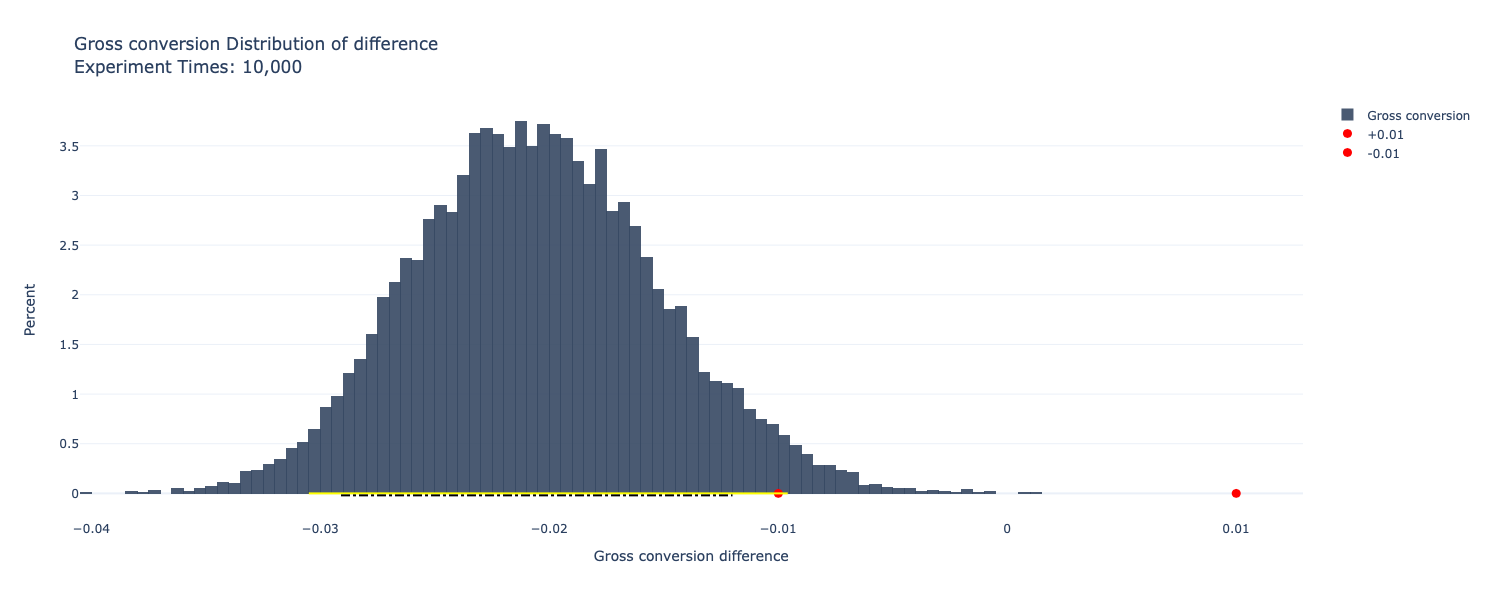

In [49]:
# Gross conversion
bootstrapped_hist(d_GC, label='Gross conversion', d_min=0.01, alpha=0.05)

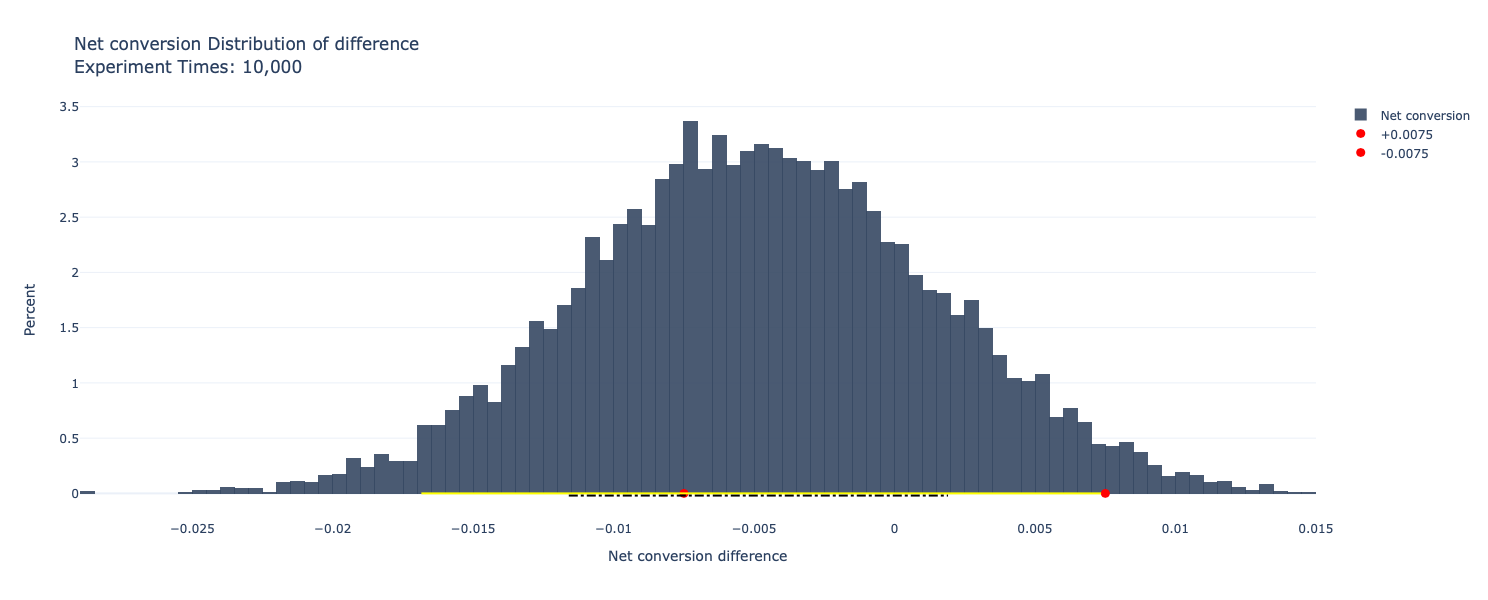

In [48]:
# Net conversion
bootstrapped_hist(d_NC, label='Net conversion', d_min=0.0075, alpha=0.05)

---

## Make a Recommendation

**Q: Finally, make a recommendation. Would you launch this experiment, not launch it, dig deeper, run a follow-up experiment, or is it a judgment call? If you would dig deeper, explain what area you would investigate. If you would run follow-up experiments, briefIy describe that experiment. If it is a judgment call, explain what factors would be relevant to the decision.**

**A:**

Recall the definitions of the following metrics:
- **Number of clicks** is the unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). 
- **Enrollments**: Number of user-ids to enroll in the free trial that day.
- **Payments**: Number of user-ids who enrolled on that day to remain enrolled for 14 days and thus make a payment. (Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns.)

To be more clear, the **Payments** is included in the **Enrollments**, which means there are two kinds of users:
- Enrolled in the "start free trial" and make a payment
- Enrolled in the "start free trial" and do not make a payment

Therefore, if we can reduce the users of enrollments but keep the payments the same. We can assign the coaching services to potential paying users effectively and have the same revenue, leading to an increase in the users experience.

---

Based on our analysis, The Confidence Interval of Gross conversion ($\displaystyle \frac{C_{enrollments}}{C_{clicks}}$) is [-0.0291, -0.012] with a 95% confidence level. And it is statistical significance and practical significance. Therefore, we are 95% confident that after applying the change (asking users who do not have 5 hours for learning per week to switch to "access course materials"), the overall enrollments decreased, which means some users decide not to enroll in the "start free trial". It will help Udacity effectively distribute the human resource to the potential paying users.

Additionally, the Confidence Interval of the Net conversion ($\displaystyle \frac{C_{payments}}{C_{clicks}}$) is [-0.0116, 0.0019] with 95% confidence level. And it neither statistical significance or practical significance. Therefore, we are 95% confident that after applying the change, there is no difference between the control and experiment, which means we stay the payments at the same level but reduce the overall users of "start free trial". Because some users of "start free trial" may not continue to check out. Our target is to suggest this kind of users switch to "access course materials".

---

In conclusion, I recommend launching this change in the production environment. It can help Udacity reach the original goal:
- Improving the experience of the rest users of “start free trials” since Udacity has less users to share the coaching services.


Beyond the one goal, there are three extra benefits: 
- With the users' experience improved, Udacity may attract more potential users.
- Or Udacity can keep the user experience at the same level and reduce the current coaching teams in order to decrease the cost.
- The change will not make a directly tremendous impact on the current revenue.

---

## Follow-Up Experiment: How to Reduce Early Cancellations

**Q: If you wanted to reduce the number of frustrated students who cancel early in the course, what experiment would you try? Give a brief description of the change you would make, what your hypothesis would be about the effect of the change, what metrics you would want to measure, and what unit of diversion you would use. Include an explanation of each of your choices.**

**A:**

The potential frustrated students have two categories:
- Category A: Students who do not finish the prerequisite courses.
- Category B: Students who have issues but cannot find any help.

`Cancellation rate` definition:
- `Gross conversion` - `Net conversion`

---

### Experiment 1

For Category A students, Udacity can ask them when they click on "start free trial". This experiment is highly similar to the current experiment.

- **Experiment**: A reminder of prerequisite courses for Free Trial
- **Goal**: Minimize the course cancellation rate of **"Free Trial"** users by guiding the improper students to the basic course.
- **Experiment Hypothesis**: The hypothesis was that this might set a clearer entrance for students who are able to finish the courses. For the students who need to finish prerequisite courses, guide them to the basic courses page, leading to a decrease in the number of frustrated students. The `clicks` will be tracked before the "free trial" started. If the experiment hypothesis is true, the experiment will have lower `enrollments`, leading to lower `Gross conversion` and higher `Net conversion`. Therefore, we have lower `Cancellation rate`.
- **Experiment Change**: For the users who click on **"start free trial"**, Udacity will ask the users whether or not they have enough basic knowledge to complete the course.
- **Unit of diversion**: cookies

Metrics:

- **Number of cookies**: That is, number of unique cookies to view the course overview page. ($d_{min}=3000$)
- **Number of user-ids**: That is, number of users who enroll in the free trial. ($d_{min}=50$)
- **Number of clicks**: That is, number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). ($d_{min}=240$)
- **Click-through-probability**: That is, number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page. ($d_{min}=0.01$)
- **Gross conversion**: That is, number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. ($d_min=0.01$)
- **Retention**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of user-ids to complete checkout. ($d_{min}=0.01$)
- **Net conversion**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. ($d_{min}=0.0075$)


---

### Experiment 2

For Category B students, Udacity can track the students' stats. For instance, make a trigger system that lets the coach contact the students who submit the wrong answers more than three times for the same question.

- **Experiment**: An initiative coaching service for frustrated students
- **Goal**: Minimize the course cancellation rate of **"Free Trial"** users by providing initiative coaching services to the students.
- **Experiment Hypothesis**: The hypothesis was that this might set a trigger system for providing initiative coaching services to the students who stuck in the quizzes or assignments. After helping the frustrated students, the course completion rate may be increased. If the hypothesis is true, the experiment will have a higher `Net conversion`. Therefore, we have a lower `Cancellation rate`.
- **Experiment Change**: For the users who click on **"start free trial"** and have issues, Udacity provides initiative coaching services.
- **Unit of diversion**: cookies

Metrics:

- **Number of cookies**: That is, number of unique cookies to view the course overview page. ($d_{min}=3000$)
- **Number of user-ids**: That is, number of users who enroll in the free trial. ($d_{min}=50$)
- **Number of clicks**: That is, number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). ($d_{min}=240$)
- **Click-through-probability**: That is, number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page. ($d_{min}=0.01$)
- **Gross conversion**: That is, number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. ($d_min=0.01$)
- **Retention**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of user-ids to complete checkout. ($d_{min}=0.01$)
- **Net conversion**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. ($d_{min}=0.0075$)